# Training and evaluation notebook

In [26]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [27]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


## 2. Add indices

In [28]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372873,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625818,0.443384,0.076328,0.432730,0.637691
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


### Subset VI table for latex

In [4]:

# Step 1: Create a subset with required columns
subset_df = merged_df[['sample_location_id', 'class', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']]

# Step 2: Group by class and get the first occurrence in each class for simplicity
# (You can replace 'first()' with 'mean()' or any other aggregation if needed)
subset_df = subset_df.groupby('class').first().reset_index()

# Step 3: Export to LaTeX
latex_table = subset_df.to_latex(index=False, caption="Vegetation Indices by Class", label="tab:veg_indices")

print(latex_table)

\begin{table}
\caption{Vegetation Indices by Class}
\label{tab:veg_indices}
\begin{tabular}{rrrrrrr}
\toprule
class & sample_location_id & NDVI & EVI & NDWI & SAVI & GNDVI \\
\midrule
0 & 201802 & 0.620752 & 0.479599 & 0.164388 & 0.436584 & 0.635948 \\
1 & 201802 & 0.706099 & 0.551265 & 0.265879 & 0.483868 & 0.651133 \\
2 & 201701 & 0.568914 & 0.246737 & -0.052386 & 0.271183 & 0.670018 \\
3 & 201801 & 0.349334 & 0.142094 & -0.331459 & 0.164678 & 0.570340 \\
4 & 202003 & 0.391720 & 0.257358 & -0.056495 & 0.252509 & 0.496575 \\
\bottomrule
\end{tabular}
\end{table}



## 3. EDA

Distribution of classes in feature space. The plot will show the spectral signature (digital number) of different bands (S2 bands) for each class, allowing you to visualize how these signatures vary across classes.

In [29]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12']

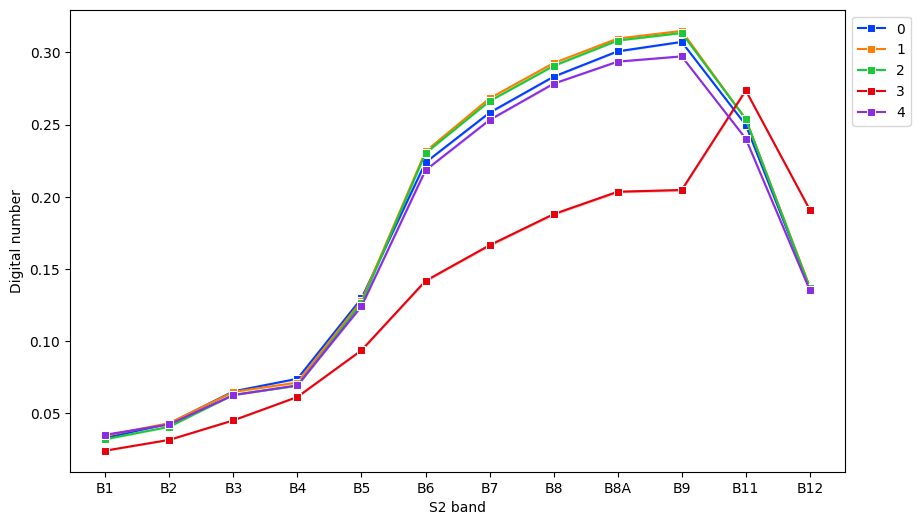

In [6]:

# Flatten the data
data_flat = pd.melt(merged_df.drop(columns =["sample_location_id", 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI'], axis=1), id_vars="class")
data_flat.columns = ["class", "S2 band", "Digital number"]

# Plot spectra using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.lineplot(data=data_flat, x="S2 band", y="Digital number", hue="class", marker="s", palette="bright")

# Adjust legend position
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

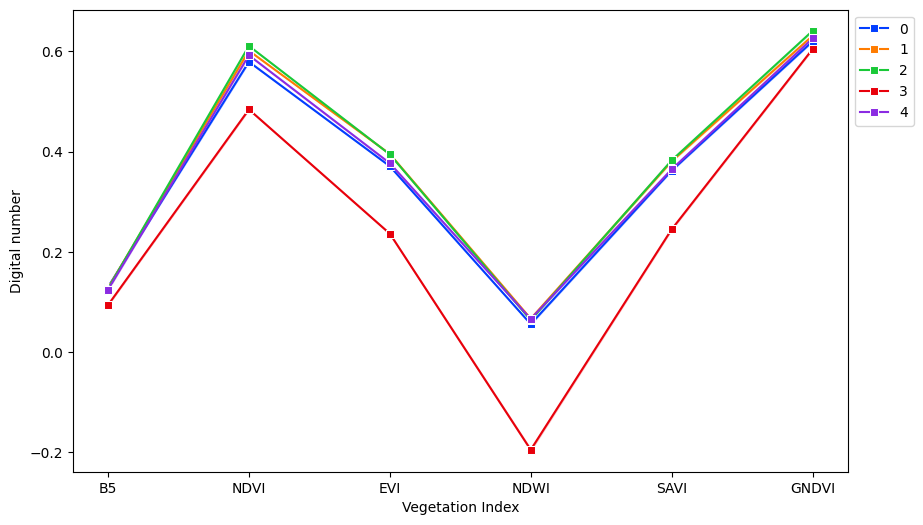

In [8]:
# Flatten the data
data_flat_1 = pd.melt(merged_df.drop(columns =["sample_location_id", 'B1', 'B2', 'B3', 'B4', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'], axis=1), id_vars="class")
data_flat_1.columns = ["class", "Vegetation Index", "Digital number"]

# Plot spectra using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.lineplot(data=data_flat_1, x="Vegetation Index", y="Digital number", hue="class", marker="s", palette="bright")

# Adjust legend position
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

TODO:

- Show distribution of classes in the dataset

- Show distributions of classes across locations

In [43]:
## type the todo's here


In [15]:
print(location_class_df.columns)

Index([0, 1, 2, 3, 4, 'total', 'Count'], dtype='object', name='class')


## 4. Constructing stratified K-fold cross validation (SKF)

Stratified just means you're trying to ensure each fold has the same relative proportion of each class so that you're training and testing on the same proportion of data for each K-fold. 



The purpose of the cell below is to find the optimal number of folds which are either individual locations or groupings of individual locations so that the relative class proportions across all folds are as balanced as possible

It's meant to save you from staring at the class distributions per location and trying to manually come up with the folds yourself. 

In [40]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In [55]:
# Unique values for the 'sample_location_ID' column
unique_locations = merged_df['sample_location_id'].unique()

# Unique values for the 'class' column
unique_classes = merged_df['classes'].unique()

print(unique_locations)
print(unique_classes)

[201701 201802 201803 201801 201804 201805 202001 202002 202003 202004
 202101 202102 202103 202104 202105 202106 202107 202108 202201 202202
 202204 202205 202207 202208 202209 202301 202302 202303 202305 202306
 202307 202308 202309 202310 202311 202312]
[2 0 1 3 4]


In [44]:
with open("location_class_counts.pkl", 'rb') as file:
    location_class_df = pd.read_pickle(file)

location_class_df

class,0,1,2,3,4,total
sample_location_id,,,,,,
201701,0.0,0.0,5553.0,0.0,0.0,5553.0
201801,0.0,0.0,0.0,26778.0,0.0,26778.0
201802,4289.0,3567.0,0.0,0.0,0.0,7856.0
201803,22341.0,0.0,0.0,319.0,0.0,22660.0
201804,0.0,0.0,0.0,24553.0,0.0,24553.0
201805,0.0,0.0,0.0,4725.0,0.0,4725.0
202001,0.0,8323.0,0.0,0.0,0.0,8323.0
202002,0.0,14663.0,20088.0,0.0,0.0,34751.0
202003,0.0,0.0,0.0,0.0,10059.0,10059.0


0 = actively eroding,
1 = drained, 
2 = modified, 
3 = bare peat, 
4 = restored, 

In [48]:
# Assuming 'classes' is your list or array of class labels
class_counts = np.bincount(classes)
print("Class distribution:", class_counts)

# Find the minimum class count
min_class_count = np.min(class_counts[class_counts > 0])  # Exclude classes with 0 samples
print("Minimum class count:", min_class_count)

Class distribution: [ 9 16 12  4 19]
Minimum class count: 4


In [56]:
# Assuming locations is the list containing location identifiers
sample_location_id = [201701, 201801, 201802, 201802, 201803, 201803, 
                      201804, 201805, 202001, 202002, 202002, 202003, 
                      202004, 202101, 202101, 202102, 202103, 202104, 
                      202105, 202106, 202106, 202106, 202106, 202107, 
                      202107, 202107, 202108, 202201, 202202, 202202, 
                      202204, 202204, 202204, 202205, 202205, 202205, 
                      202205, 202207, 202208, 202208, 202208, 202209, 
                      202301, 202302, 202303, 202303, 202303, 202305, 
                      202306, 202307, 202308, 202308, 202308, 202309, 
                      202310, 202310, 202310, 202311, 202312, 202312]  # Replace with your actual data
# Assuming classes is the list containing class labels
classes = [2, 3, 0, 1, 0, 3, 3, 3, 1, 1, 2, 4, 4, 1, 2,
           1, 4, 1, 4, 0, 1, 2, 4, 0, 1, 2, 2, 4, 1, 2,
           0, 1, 4, 0, 1, 2, 4, 4, 0, 1, 4, 4, 4, 1, 1,
           2, 4, 4, 4, 4, 0, 1, 2, 4, 0, 2, 4, 4, 1, 2]  # Replace with your actual class labels

# Revised count_class_proportions function
def count_class_proportions(folds, classes_array):
    classes_array = np.array(classes_array)
    class_proportions = []
    for _, train_idx in folds:
        train_idx = np.array(train_idx, dtype=int)
        fold_counts = np.bincount(classes_array[train_idx], minlength=len(np.unique(classes_array)))
        fold_proportions = fold_counts / len(train_idx)
        class_proportions.append(fold_proportions)
    return class_proportions

# Your existing perform_skf function remains unchanged
def perform_skf(n_splits, sample_location_id, classes):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    return list(skf.split(np.zeros_like(sample_location_id), classes, sample_location_id))

best_k = None
min_class_proportion_diff = float('inf')
best_fold_assignments = None

# Ensure k does not exceed 4, as the smallest class has 4 samples
max_splits = 4  # Based on the minimum class count

for k in range(2, min(max_splits, len(set(sample_location_id))) + 1):  # Adjust the range for k
    folds = perform_skf(k, sample_location_id, classes)
    class_proportions = count_class_proportions(folds, classes)
    
    # Calculate the maximum difference in class proportions across folds
    max_diff = np.max(np.abs(np.diff(class_proportions, axis=0)))

    # Update the best K if the current K results in a smaller maximum difference
    if max_diff < min_class_proportion_diff:
        min_class_proportion_diff = max_diff
        best_k = k
        best_fold_assignments = folds

# Print the best K
print("Best K for SKF:", best_k)

# Print the fold assignments for each location
for fold_num, (_, train_idx) in enumerate(best_fold_assignments, 1):
    locations_in_fold = np.unique(np.array(sample_location_id)[train_idx])
    print(f"Fold {fold_num}: location {', '.join(map(str, locations_in_fold))}")

Best K for SKF: 2
Fold 1: location 201801, 201802, 201803, 202002, 202004, 202101, 202103, 202104, 202105, 202106, 202107, 202108, 202202, 202204, 202207, 202208, 202303, 202306, 202307, 202308, 202310, 202311
Fold 2: location 201701, 201802, 201804, 201805, 202001, 202002, 202003, 202101, 202102, 202106, 202107, 202201, 202204, 202205, 202208, 202209, 202301, 202302, 202303, 202305, 202308, 202309, 202312


## 5. training / evaluating 

start with a baseline model, the simplest possible model, using logistic regression on the SKF you sorted out above. This establishes your baseline. 

In [59]:
# Check for any NaN values in the DataFrame
nan_exists = merged_df.isnull().values.any()

# Print result
print(f"Are there any NaN values in the DataFrame? {nan_exists}")

Are there any NaN values in the DataFrame? True


In [60]:
# Get the count of NaNs in each column
nan_counts = merged_df.isnull().sum()

# Print columns with NaN counts greater than 0
print(nan_counts[nan_counts > 0])

NDVI     1
NDWI     1
GNDVI    1
dtype: int64


In [61]:
merged_df = merged_df.dropna()

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare features (X) and target (y)
features = merged_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
target = merged_df['classes'].values

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)  # best_k determined from your previous code

accuracy_scores = []
scaler = StandardScaler()

for train_index, test_index in skf.split(features, target):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Logistic Regression Model with increased max_iter and adjusted C
    model = LogisticRegression(max_iter=5000, C=10)
    model.fit(X_train_scaled, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the Model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy across all folds: {average_accuracy}")

Average Accuracy across all folds: 0.4983813464491113


Suppose you want to find the best hyperparameter setting for your models:

you could use something like OPtuna and do it below, using k-fold cross validation, using the k and location splits above

In [25]:
## hyperparameter optimization code here (I'd use optuna)

You have your final model(s) and you can evaluate them in the cell below:

In [ ]:


# Assuming X contains your feature data, y contains your class labels
# and classifier is your classification model
# You may need to replace this with the actual classifier you are using

# Example classifier (replace with your actual classifier)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

# Assuming X, y are your feature data and class labels
# n_splits is the number of folds for cross-validation
n_splits = best_k  # Adjust as needed

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
precision_list = []
recall_list = []
accuracy_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train your classifier on K-1 folds
    classifier.fit(X_train, y_train)

    # Predict on the Kth fold
    y_pred = classifier.predict(X_test)

    # Calculate evaluation metrics for the current fold
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    # Append metrics to lists
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)

# Calculate average metrics across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_accuracy = np.mean(accuracy_list)

# Print or use the average metrics as needed
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average Accuracy:", average_accuracy)


- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

Feature permutation importance

In [ ]:
## run feature permutation importance here. 
## Gives you an indication of which features are the most important for good classification performance

## 6. (?) collapsing classes into fewer classes

I don't know where it's most intuitive for you to do this. Maybe you make an entire separate notebook for this for the collapsed classes - that would be the neatest thing to do. But run through the same process with these collapsed classes. 